In [469]:
# To being please install PyPlot by uncomment the line below
# Pkg.add("PyPlot")
using PyPlot
srand(4242); # Reseed the random number generator with 4242

For these examples we will be using the convex optimization function $ f(x) = \frac{1}{2} x^2 $ because the gradient is simply $ f(x) = x $ as such the function is as follows:

In [470]:
function grad_f(x)
    return x
end

grad_f (generic function with 1 method)

Suppose that our samples are of the form
$$\tilde f(x) = \frac{1}{2} (x + z)^2$$
where $z \sim N(0,1)$ is a standard Gaussian random variable. Then
$$ \nabla \tilde f(x) = x + z $$
As such with each step the simplified SGD function would be:
$$x_{t+1} = x_t-\alpha\nabla \tilde f(x_t)$$

In [471]:
function sample_grad_f(x)
    # Sample between (0,1)
    return x + randn(length(x)) / sqrt(length(x))
end

sample_grad_f (generic function with 1 method)

In [472]:
function gradient_descent(x0, alpha, num_iters)
    dist_to_optimum = zeros(num_iters) # Distance to optimimum is initialized
    x = x0 # set x = initial x0
    for t = 1:num_iters # set num_iters
        dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
        x = x - alpha * grad_f(x) # this is running the simple GD equation without sampling
    end
    return dist_to_optimum
end

function stochastic_gradient_descent(x0, alpha, num_iters)
    dist_to_optimum = zeros(num_iters) # Distance to optimium is initialized
    x = x0 # set x = initial x0
    for t = 1:num_iters # set num_iters
        dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
        x = x - alpha * sample_grad_f(x) # this is the running the SGD
    end
    return dist_to_optimum
end

function stochastic_gradient_descent_until(x0, alpha, accuracy, num_iters)
    x = x0
    for t = 1:num_iters
        x = x - alpha * sample_grad_f(x)
        if norm(x) <= accuracy
            return t
        end
    end
    return num_iters
end

stochastic_gradient_descent_until (generic function with 1 method)

If we were to add SGD + VR
$$x_{t+1} = x_t-\alpha(\nabla \tilde f(x_t)-\nabla \tilde f( \tilde x_t) + \tilde \mu)$$

In [728]:
# Implementing SVRG
function stochastic_varience_reduced_gradient(x0, alpha, num_epochs, num_iters, last=true)
    # initial seeding of dist_to_optimum 
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = dist_to_optimum
    for e = 1:num_epochs # Run for num_epochs
        x_star = last ? dist_to_optimum[end] : dist_to_optimum[rand(1:end)] # different option based on last
        mu = mean(grad_f(dist_to_optimum)) # average across all grad_f(x) per epoch
        x = e==1 ? x0 : x_star # set as x_star
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            x = x - alpha * (sample_grad_f(x)-grad_f(x_star) + mu) # this is the running the SGD
        end
        final_dist_to_optimum = hcat(final_dist_to_optimum,dist_to_optimum)
    end
    return vec(final_dist_to_optimum)
end

function stochastic_varience_reduced_gradient_until(x0, alpha, num_epochs, num_iters, accuracy, last=true)
    # initial seeding of dist_to_optimum 
    dist_to_optimum = zeros(num_iters)
    for e = 1:num_epochs # Run for num_epochs
        x_star = last ? dist_to_optimum[end] : dist_to_optimum[rand(1:end)] # different option based on last
        mu = mean(grad_f(dist_to_optimum)) # average across all grad_f(x) per epoch
        x = e==1 ? x0 : x_star # set as x_star
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            x = x - alpha * (sample_grad_f(x)-grad_f(x_star) + mu) # this is the running the SGD
            if norm(x) <= accuracy
                return ((e-1)*t)+t
            end
        end
    end
    return (e-1)*t
end

stochastic_varience_reduced_gradient_until (generic function with 3 methods)

In [729]:
x0 = 5 * randn(1000);
num_iters = 1000000;
num_epochs = 3;
accuracy = 1.0;

In [730]:
stochastic_varience_reduced_gradient_until(x0,0.5,num_epochs,num_iters,accuracy)>=
    stochastic_gradient_descent_until(x0,0.5,accuracy,num_iters)

true

In [731]:
function stochastic_gradient_descent_diminishing(x0, num_iters)
    dist_to_optimum = zeros(num_iters)
    alphas = zeros(num_iters)
    x = x0
    mu = 1.0
    M = 1.0
    rho0 = norm(x0)^2
    for t = 1:num_iters
        alpha = (2 * mu * rho0) / (4 * M + mu^2 * rho0 * (t-1))
        alphas[t] = alpha
        dist_to_optimum[t] = norm(x)
        x = x - alpha * sample_grad_f(x)
    end
    return (alphas, dist_to_optimum)
end

stochastic_gradient_descent_diminishing (generic function with 1 method)

In [762]:
x0 = randn(100) / 10;
(alphas, dto_diminishing) = stochastic_gradient_descent_diminishing(x0, 10000);

alpha1 = 0.5 * norm(x0)^2; # same as first step
alpha2 = 2 / (4 + norm(x0)^2 * 100); # intermediate
alpha3 = 2 / (4 + norm(x0)^2 * 1000); # same as last step

dto1 = stochastic_gradient_descent(x0, alpha1, 10000);
dto2 = stochastic_gradient_descent(x0, alpha2, 10000);
dto3 = stochastic_gradient_descent(x0, alpha3, 10000);
dto4 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333);
dto5 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333);
dto6 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333);
dto7 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333, false);
dto8 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333, false);
dto9 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333, false);

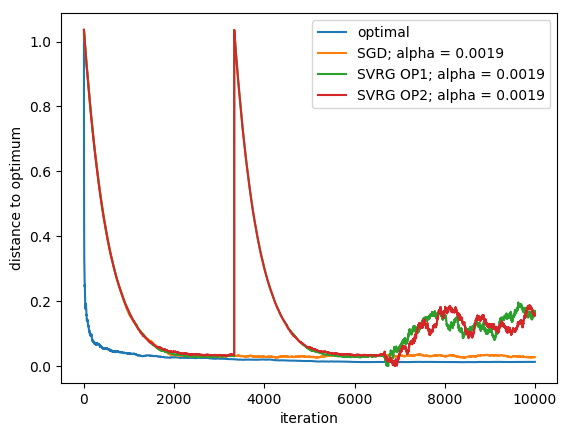

In [763]:
plot(dto_diminishing, label="optimal");
# plot(dto1; label = "SGD; alpha = $(signif(alpha1, 2))");
# plot(dto2; label = "SGD; alpha = $(signif(alpha2, 2))");
plot(dto3; label = "SGD; alpha = $(signif(alpha3, 2))");
# plot(dto4; label = "SVRG OP1; alpha = $(signif(alpha1, 2))");
# plot(dto5; label = "SVRG OP1; alpha = $(signif(alpha2, 2))");
plot(dto6; label = "SVRG OP1; alpha = $(signif(alpha3, 2))");
# plot(dto7; label = "SVRG OP2; alpha = $(signif(alpha1, 2))");
# plot(dto8; label = "SVRG OP2; alpha = $(signif(alpha2, 2))");
plot(dto9; label = "SVRG OP2; alpha = $(signif(alpha3, 2))");
xlabel("iteration");
ylabel("distance to optimum");
legend();

When looking at strategies for precision this changes as there are 5 different options that we are looking at:
1. $x_{t+1} = x_t-Q(\alpha \nabla \tilde f(x_t)-\alpha \nabla \tilde f( \tilde x_t) + \alpha \tilde \mu)$ where we implmenent naive low-precision SVRG

In [785]:
# Implementing SVRG + Precision
function stochastic_varience_reduced_gradient_precision_1(x0, alpha, num_epochs, num_iters, FL, IL=Int8, last=true)
    # initial seeding of dist_to_optimum 
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = dist_to_optimum
    for e = 1:num_epochs # Run for num_epochs
        x_star = last ? dist_to_optimum[end] : dist_to_optimum[rand(1:end)] # different option based on last
        mu = mean(grad_f(dist_to_optimum)) # average across all grad_f(x) per epoch
        x = e==1 ? map(x -> convert(Fixed{IL,FL},x), x0) : x_star # set as x_star
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            x = x - map(x -> convert(Fixed{IL,FL},x),(alpha * (sample_grad_f(x)-grad_f(x_star) + mu))) # this is the running the SGD
        end
        final_dist_to_optimum = hcat(final_dist_to_optimum,dist_to_optimum)
    end
    return vec(final_dist_to_optimum)
end

function stochastic_gradient_descent_precision(x0, alpha, num_iters, FL, IL=Int8)
    dist_to_optimum = zeros(num_iters) # Distance to optimium is initialized
    x = map(y -> convert(Fixed{IL,FL},y),x0) # set x = initial x0
    for t = 1:num_iters # set num_iters
        dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
        x = x - map(y -> convert(Fixed{IL,FL},y), (alpha * sample_grad_f(x))) # this is the running the SGD
    end
    return dist_to_optimum
end

stochastic_gradient_descent_precision (generic function with 2 methods)

In [786]:
using FixedPointNumbers

In [814]:
x0 = randn(100) / 10;
(alphas, dto_diminishing) = stochastic_gradient_descent_diminishing(x0, 10000);

alpha1 = 0.5 * norm(x0)^2; # same as first step
alpha2 = 2 / (4 + norm(x0)^2 * 100); # intermediate
alpha3 = 2 / (4 + norm(x0)^2 * 1000); # same as last step

dto1 = stochastic_gradient_descent(x0, alpha1, 10000);
dto2 = stochastic_gradient_descent(x0, alpha2, 10000);
dto3 = stochastic_gradient_descent(x0, alpha3, 10000);
dto4 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333);
dto5 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333);
dto6 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333);
dto7 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333, false);
dto8 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333, false);
dto9 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333, false);
dto10 = stochastic_gradient_descent_precision(x0, alpha3, 10000, 10, Int16);
dto11 = stochastic_varience_reduced_gradient_precision_1(x0, alpha3, 2, 3333, 16, Int16, false);

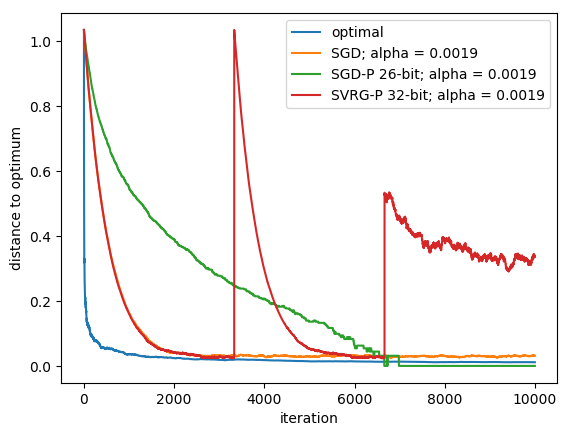

In [815]:
plot(dto_diminishing, label="optimal");
# plot(dto1; label = "SGD; alpha = $(signif(alpha1, 2))");
# plot(dto2; label = "SGD; alpha = $(signif(alpha2, 2))");
plot(dto3; label = "SGD; alpha = $(signif(alpha3, 2))");
# plot(dto4; label = "SVRG OP1; alpha = $(signif(alpha1, 2))");
# plot(dto5; label = "SVRG OP1; alpha = $(signif(alpha2, 2))");
# plot(dto6; label = "SVRG OP1; alpha = $(signif(alpha3, 2))");
# plot(dto7; label = "SVRG OP2; alpha = $(signif(alpha1, 2))");
# plot(dto8; label = "SVRG OP2; alpha = $(signif(alpha2, 2))");
# plot(dto9; label = "SVRG OP2; alpha = $(signif(alpha3, 2))");
plot(dto10; label = "SGD-P 26-bit; alpha = $(signif(alpha3, 2))");
plot(dto11; label = "SVRG-P 32-bit; alpha = $(signif(alpha3, 2))");
# plot(dto12; label = "SVRG-P 12-bit; alpha = $(signif(alpha3, 2))");
# plot(dto13; label = "SVRG-P 10-bit; alpha = $(signif(alpha3, 2))");
# plot(dto14; label = "SVRG-P 9-bit; alpha = $(signif(alpha3, 2))");
xlabel("iteration");
ylabel("distance to optimum");
legend();

2 .  $x_{t+1} = x_t-Q(\alpha \nabla \tilde f(x_t)-\alpha \nabla \tilde f( \tilde x_t)) - g_z$ ; $g_z = Q(\alpha\tilde \mu)$ where we Quantize $\alpha\tilde \mu$ as soon as it's computed

In [836]:
# Implementing SVRG + Precision Option 2
function stochastic_varience_reduced_gradient_precision_2(x0, alpha, num_epochs, num_iters, FL, IL=Int8, last=true)
    # initial seeding of dist_to_optimum 
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = dist_to_optimum
    for e = 1:num_epochs # Run for num_epochs
        x_star = last ? dist_to_optimum[end] : dist_to_optimum[rand(1:end)] # different option based on last
        g_z = convert(Fixed{IL,FL},alpha*mean(grad_f(dist_to_optimum))) # average across all grad_f(x) per epoch
        x = e==1 ? map(x -> convert(Fixed{IL,FL},x), x0) : x_star # set as x_star
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            x = x - map(x -> convert(Fixed{IL,FL},x),(alpha * (sample_grad_f(x)-grad_f(x_star)))) - g_z # this is the running the SGD
        end
        final_dist_to_optimum = hcat(final_dist_to_optimum,dist_to_optimum)
    end
    return vec(final_dist_to_optimum)
end

stochastic_varience_reduced_gradient_precision_2 (generic function with 4 methods)

In [849]:
x0 = randn(100) / 10;
(alphas, dto_diminishing) = stochastic_gradient_descent_diminishing(x0, 10000);

alpha1 = 0.5 * norm(x0)^2; # same as first step
alpha2 = 2 / (4 + norm(x0)^2 * 100); # intermediate
alpha3 = 2 / (4 + norm(x0)^2 * 1000); # same as last step

dto1 = stochastic_gradient_descent(x0, alpha1, 10000);
dto2 = stochastic_gradient_descent(x0, alpha2, 10000);
dto3 = stochastic_gradient_descent(x0, alpha3, 10000);
dto4 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333);
dto5 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333);
dto6 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333);
dto7 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333, false);
dto8 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333, false);
dto9 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333, false);
dto10 = stochastic_gradient_descent_precision(x0, alpha3, 10000, 10, Int16);
dto11 = stochastic_varience_reduced_gradient_precision_1(x0, alpha3, 2, 3333, 10, Int16, false);
dto12 = stochastic_varience_reduced_gradient_precision_2(x0, alpha3, 2, 3333, 10, Int16, false);

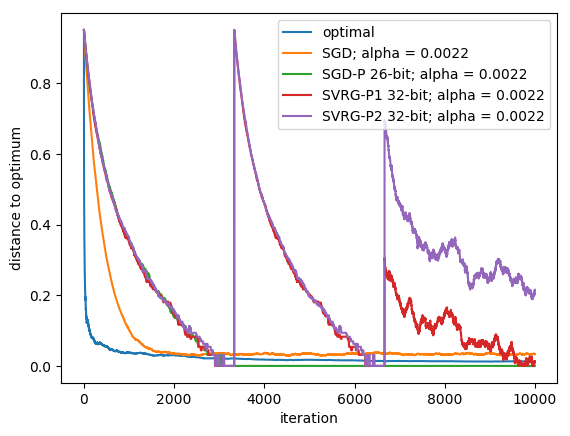

In [850]:
plot(dto_diminishing, label="optimal");
# plot(dto1; label = "SGD; alpha = $(signif(alpha1, 2))");
# plot(dto2; label = "SGD; alpha = $(signif(alpha2, 2))");
plot(dto3; label = "SGD; alpha = $(signif(alpha3, 2))");
# plot(dto4; label = "SVRG OP1; alpha = $(signif(alpha1, 2))");
# plot(dto5; label = "SVRG OP1; alpha = $(signif(alpha2, 2))");
# plot(dto6; label = "SVRG OP1; alpha = $(signif(alpha3, 2))");
# plot(dto7; label = "SVRG OP2; alpha = $(signif(alpha1, 2))");
# plot(dto8; label = "SVRG OP2; alpha = $(signif(alpha2, 2))");
# plot(dto9; label = "SVRG OP2; alpha = $(signif(alpha3, 2))");
plot(dto10; label = "SGD-P 26-bit; alpha = $(signif(alpha3, 2))");
plot(dto11; label = "SVRG-P1 26-bit; alpha = $(signif(alpha3, 2))");
plot(dto12; label = "SVRG-P2 26-bit; alpha = $(signif(alpha3, 2))");
xlabel("iteration");
ylabel("distance to optimum");
legend();

3 . $x_{t+1} = x_t-Q_b(\alpha \nabla \tilde f(x_t)-\alpha \nabla \tilde f( \tilde x_t)) + \alpha g_z$ ; $g_z = Q_{2b}(\tilde \mu)$ 

In [851]:
# Implementing SVRG + Precision
function stochastic_varience_reduced_gradient_precision_3(x0, alpha, num_epochs, num_iters, FL, IL=Int8, last=true)
    # initial seeding of dist_to_optimum 
    doubling = IL==Int8 ? Int16 : Int32
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = dist_to_optimum
    for e = 1:num_epochs # Run for num_epochs
        x_star = last ? dist_to_optimum[end] : dist_to_optimum[rand(1:end)] # different option based on last
        g_z = convert(Fixed{doubling,FL*2},alpha*mean(grad_f(dist_to_optimum))) # average across all grad_f(x) per epoch
        x = e==1 ? map(x -> convert(Fixed{IL,FL},x), x0) : x_star # set as x_star
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            x = x - map(x -> convert(Fixed{IL,FL},x),(alpha * (sample_grad_f(x)-grad_f(x_star)))) - g_z # this is the running the SGD
        end
        final_dist_to_optimum = hcat(final_dist_to_optimum,dist_to_optimum)
    end
    return vec(final_dist_to_optimum)
end

stochastic_varience_reduced_gradient_precision_3 (generic function with 3 methods)

In [ ]:
x0 = randn(100) / 10;
(alphas, dto_diminishing) = stochastic_gradient_descent_diminishing(x0, 10000);

alpha1 = 0.5 * norm(x0)^2; # same as first step
alpha2 = 2 / (4 + norm(x0)^2 * 100); # intermediate
alpha3 = 2 / (4 + norm(x0)^2 * 1000); # same as last step

dto1 = stochastic_gradient_descent(x0, alpha1, 10000);
dto2 = stochastic_gradient_descent(x0, alpha2, 10000);
dto3 = stochastic_gradient_descent(x0, alpha3, 10000);
dto4 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333);
dto5 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333);
dto6 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333);
dto7 = stochastic_varience_reduced_gradient(x0, alpha1, 2, 3333, false);
dto8 = stochastic_varience_reduced_gradient(x0, alpha2, 2, 3333, false);
dto9 = stochastic_varience_reduced_gradient(x0, alpha3, 2, 3333, false);
dto10 = stochastic_gradient_descent_precision(x0, alpha3, 10000, 10, Int16);
dto11 = stochastic_varience_reduced_gradient_precision_1(x0, alpha3, 2, 3333, 10, Int16, false);
dto12 = stochastic_varience_reduced_gradient_precision_2(x0, alpha3, 2, 3333, 10, Int16, false);
dto13 = stochastic_varience_reduced_gradient_precision_3(x0, alpha3, 2, 3333, 10, Int16, false);